# Introduction to MindSphere Analytics APIs - KPI Calculation

This demo will use the mindconnect-nodejs CLI to call the mindsphere APIs. 
The information about the installation and usage of CLI:

https://opensource.mindsphere.io/docs/mindconnect-nodejs/cli/index.html


You will need to get and configure the service credentials to use this notebook. 
Here is a description how to acquire and setup the service credentials:

https://opensource.mindsphere.io/docs/mindconnect-nodejs/li/setting-up-the-cli.html

This is only a **demo** for the MindSphere KPI calculation API 

https://developer.mindsphere.io/apis/analytics-kpicalculation/api-kpicalculation-overview.html



## Setup the mindconnect-nodejs CLI

please change the line below to the passkey you were using when setting up the service credentials:

In [49]:
passkey = "passkey.4.unit.test"

## KPI Calculation with CLI

```mc kpi-calculation``` CLI command:

In [50]:
!mc kpi-calculation --help

Usage: mc kpi-calculation|kp [options]

calculate kpi states or compute kpis @

Options:
  -f, --file <timeseries>            timeseries file (default:
                                     "timeseries-sample.json")
  -c, --calendar <calendar>          timeseries with planned outages
  -e, --events <events>              timeseries with control system events
  -m, --mode [states|kpis]           mode see @ Additional Documentation
  -t, --target <target>              target variable
  -n, --initialstate <initialstate>  Initial state [RSH, SH, POH, FOH]
                                     (default: "RSH")
  -d, --defaultstate <defaultstate>  Default state [RSH, FOH] (default: "FOH")
  -h, --threshold <threshold>        threshold parameter (default: 1)
  -s, --shutdown <shutdown>          shutdown threshold parameter in
                                     milliseconds (default: 5000)
  -y, --retry <number>               retry attempts before giving up (default:
                           

## Setup the jupyter notebook

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import json
from pandas import json_normalize
plt.rcParams['figure.figsize'] = [8, 8]

## Calculating KPIs

This uses the example request from the documentation for calculation

![](https://developer.mindsphere.io/apis/analytics-kpicalculation/images/Use-case-1-Example.png)

## Industrial Pump - TimeSeries Data

We will use the downloaded industrial pump data from MindSphere to try to fit the model which can predict flow problems. 
The mindsphere demo application is available at

https://dreamforce.mindconnect.rocks

This application can be used without mindsphere credentials. 
* username: guest@mindsphere.io
* password: Siemens123!

Following data was recorded over the time:

- **Flow** - Water flow through the pump
- **MotorCurrent** Motor Current
- **PressureIn** Inlet pressure
- **PressureOut** Outlet pressure
- **StuffingBoxTemperature** The temperature of the pump

![pumpschema](./images/Pump-Station-Scheme.jpg)

The historic data was downloaded from MindSphere and  is available in the **data** directory of this notebook.


In [ ]:
data = pd.read_json("./data/kpis/sample-timeseries.json")
data.plot(x="_time")

## First look at the data

The first file already has a typical behavior of the malfunctioning pump. The stuffing box temperature is increased and the flow is dropping.

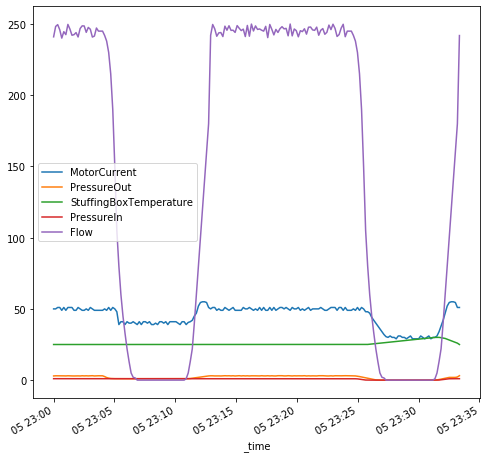

In [52]:
data = pd.read_json("./data/PUMP-011/PumpData/PumpData_0.json")
data.plot(x="_time")

## Determining the KPI States

We will use the PUMP-011 data which is showing problems with flow availability.

See also : https://developer.mindsphere.io/apis/analytics-kpicalculation/api-kpicalculation-overview.html


In [53]:
data.head(10)

,MotorCurrent,PressureOut,StuffingBoxTemperature,PressureIn,_time,Flow
0,50.0,2.92081,25.0,1.0,2020-02-05 23:00:00.278000+00:00,240.996
1,50.0,3.02930,25.0,1.0,2020-02-05 23:00:10.332000+00:00,248.293
2,51.0,3.03644,25.0,1.0,2020-02-05 23:00:20.385000+00:00,249.549
3,51.0,2.97076,25.0,1.0,2020-02-05 23:00:30.441000+00:00,245.991
4,49.0,3.09670,25.0,1.0,2020-02-05 23:00:40.496000+00:00,240.101
5,51.0,2.98840,25.0,1.0,2020-02-05 23:00:50.560000+00:00,244.602
6,49.0,2.94345,25.0,1.0,2020-02-05 23:01:00.615000+00:00,242.534
7,51.0,3.04051,25.0,1.0,2020-02-05 23:01:10.668000+00:00,249.716
8,51.0,2.95434,25.0,1.0,2020-02-05 23:01:20.729000+00:00,246.405
9,51.0,2.94290,25.0,1.0,2020-02-05 23:01:30.786000+00:00,242.101


## KPI State Calculation 

First step is to calculate the corresponding KPI states from the Flow signal. We will assume that the flow must be > 200 for the machine to be running. 


In [56]:
!mc kpi-calculation \
--mode states \
--file "./data/PUMP-011/PumpData/PumpData_0.json" \
--target State \
--threshold 200 \
--shutdown 20000 \
--passkey $passkey \
> temp/states.json

with open('temp/states.json') as f:
  data = json.load(f)

df = json_normalize (data)
df


,_time,state,source
0,2020-02-05T23:00:00.278Z,RSH,DEFAULT
1,2020-02-05T23:00:10.332Z,RSH,DEFAULT
2,2020-02-05T23:00:20.385Z,RSH,DEFAULT
3,2020-02-05T23:00:30.441Z,RSH,DEFAULT
4,2020-02-05T23:00:40.496Z,RSH,DEFAULT
...,...,...,...
195,2020-02-05T23:32:41.097Z,RSH,DEFAULT
196,2020-02-05T23:32:51.150Z,RSH,DEFAULT
197,2020-02-05T23:33:01.206Z,RSH,DEFAULT
198,2020-02-05T23:33:11.261Z,RSH,DEFAULT


## Calculating KPIs

We will now calculate the KPIs for the selected time period:

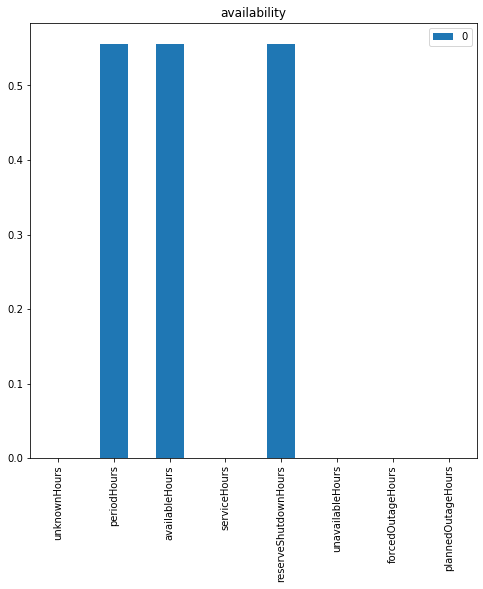

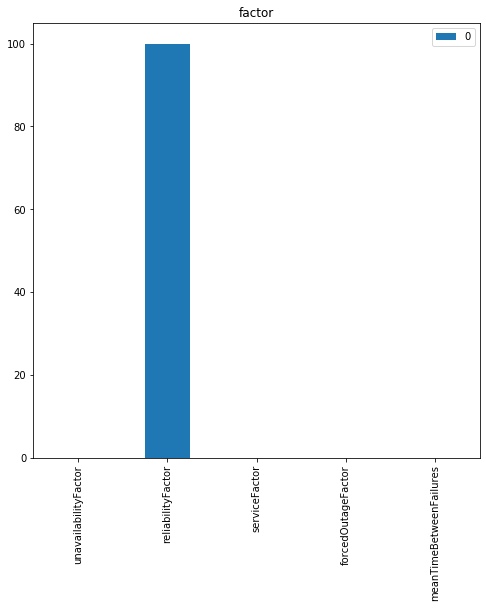

In [99]:
result = !mc kpi-calculation \
--mode kpis \
--file "temp/states.json" \
--target State \
--passkey $passkey \
> temp/kpi.json

with open('temp/kpi.json') as f:
  data = json.load(f)

df = json_normalize (data).transpose()
df[0:8].plot(kind="bar", title="availability")
df[9:].plot(kind="bar", title="factor")


## Siemens API Notice

This project has been released under an Open Source license. The release may include and/or use APIs to Siemens’ or third parties’ products or services. In no event shall the project’s Open Source license grant any rights in or to these APIs, products or services that would alter, expand, be inconsistent with, or supersede any terms of separate license agreements applicable to those APIs. “API” means application programming interfaces and their specifications and implementing code that allows other software to communicate with or call on Siemens’ or third parties’ products or services and may be made available through Siemens’ or third parties’ products, documentations or otherwise.